In [2]:
import pandas as pd
import random
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.preprocessing import timeseries_dataset_from_array


In [3]:
# load the ED visits dataset that has been cleaned and preprocessed
df_event_log_dl = pd.read_csv('df_event_log_visits_for_ML_randomorder.csv')

In [4]:
df_event_log_dl.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494784 entries, 0 to 494783
Data columns (total 43 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   SID                             494784 non-null  object 
 1   SEX                             494784 non-null  int64  
 2   VISIT_ID                        494784 non-null  object 
 3   VISIT_AGE                       494784 non-null  float64
 4   CTAS                            494784 non-null  float64
 5   Case_Duration_Hours             494784 non-null  float64
 6   PRESENTING_COMPLAINT_ENCODED    494784 non-null  int64  
 7   Is_Deceased                     494784 non-null  int64  
 8   Died_Before_Visit               494784 non-null  int64  
 9   Died_During_Visit               494784 non-null  int64  
 10  Died_After_Visit                494784 non-null  int64  
 11  Distance_to_Hospital            494784 non-null  float64
 12  Is_NL_Holiday   

## Case Features:
Case features are attributes that are the same across all events within a single case (visit). 

In this case:

SID - Patient or session identifier (will be omitted for modeling as it doesn't add predictive value).

SEX - remains constant per case.

VISIT_ID - Case identifier - identifies the specific visit; constant for all events within that visit.

VISIT_AGE - Age of the patient, constant for the visit.

Is_Deceased - case attribute.

Distance_to_Hospital - constant for a given visit.

Is_NL_Holiday - constant for the visit.

Day_of_Week - constant for the visit.

Is_Weekend - constant for the visit.

Visit_Frequency - case-level feature.

Prior_LWBS - case-level feature.

Facility_IDs - case-level features.

Case_Duration_Hours - Duration of the case or visit, case-level feature.
                
Daily_Imaging_Tests - number of total imaging tests done daily.  

Daily_Lab_Tests - number of total lab tests done daily.  

TIME_OF_THE_DAY_Ordinal - time of the day at the arrival of the patient, case-level feature.

Visit_Season_Ordinal - Season of the visit, specific to a case. 




## Event Features:
Event features are those that can vary from one event to another within the same visit:

CTAS - Triage score which can change if re-triaged during a visit.

ED_Business_Hourly - How busy the ED was, potentially varying hourly.

Activity_Encoded - varies by activity occurring during the visit. 

Is_LWBS - Indicates if the patient left without being seen, which is 
an outcome or event-specific feature.

Activity_Duration - Duration of specific activities within a visit.

Disposition_Frequency - Frequency of specific dispositions within the case, which could potentially vary as events unfold.

Inverse_CTAS_y - shows acuity score of cases per hour per site.

Rolling_Std_Inverse_CTAS - standard deviation of the acuity score. 

Num_Imaging_Tests - number of imaging done during one visit.

Num_Lab_Tests - number of lab tests done during one visit.

PRESENTING_COMPLAINT_ENCODED - presenting complaint tied to visit.

Died_Before_Visit - This indicates whether the patient died before the specific visit.

Died_During_Visit -  This indicates whether the patient died during the specific visit.

Died_After_Visit - This indicates whether the patient died after the specific visit.

Mean_Age - mean age calculated per each hour.

Unique_Presenting_Complaints - number of unique presenting complaints calculated per each hour.


In [5]:

# Dictionary to rename the columns
rename_dict = {
    'SID': 'case:SID',
    'SEX': 'case:SEX',
    'VISIT_ID': 'case:VISIT_ID',
    'VISIT_AGE': 'case:VISIT_AGE',
    'Case_Duration_Hours': 'case:Case_Duration_Hours',
    'PRESENTING_COMPLAINT_ENCODED':'event:PRESENTING_COMPLAINT_ENCODED',
    'Is_Deceased': 'case:Is_Deceased',
    'Distance_to_Hospital': 'case:Distance_to_Hospital',
    'Is_NL_Holiday': 'case:Is_NL_Holiday',
    'Day_of_Week': 'case:Day_of_Week',
    'Is_Weekend': 'case:Is_Weekend',
    'Visit_Frequency': 'case:Visit_Frequency',
    'Prior_LWBS': 'case:Prior_LWBS',
    'FACILITY_ID_BUR': 'case:FACILITY_ID_BUR',
    'FACILITY_ID_CGH': 'case:FACILITY_ID_CGH',
    'FACILITY_ID_GBC': 'case:FACILITY_ID_GBC',
    'FACILITY_ID_HSC': 'case:FACILITY_ID_HSC',
    'FACILITY_ID_SCM': 'case:FACILITY_ID_SCM',
    'TIME_OF_THE_DAY_Ordinal': 'case:TIME_OF_THE_DAY_Ordinal',
    'Visit_Season_Ordinal': 'case:Visit_Season_Ordinal',
    'CTAS': 'event:CTAS',
    'ED_Business_Hourly': 'event:ED_Business_Hourly',
    'Inverse_CTAS_y': 'event:Inverse_CTAS_y',
    'Rolling_Std_Inverse_CTAS': 'event:Rolling_Std_Inverse_CTAS',
    'Mean_Age': 'event:Mean_Age',
    'Unique_Presenting_Complaints': 'event:Unique_Presenting_Complaints',
    'Is_LWBS': 'event:Is_LWBS',
    'Activity_Duration': 'event:Activity_Duration',
    'Disposition_Frequency': 'event:Disposition_Frequency',
    'Died_Before_Visit': 'event:Died_Before_Visit',
    'Died_During_Visit': 'event:Died_During_Visit',
    'Died_After_Visit': 'event:Died_After_Visit',
    'Num_Imaging_Tests': 'event:Num_Imaging_Tests',
    'Num_Lab_Tests': 'event:Num_Lab_Tests',
    'Daily_Imaging_Tests': 'case:Daily_Imaging_Tests',
    'Daily_Lab_Tests': 'case:Daily_Lab_Tests',
    'Activity_Admitting patient': 'event:Activity_Admitting patient',
    'Activity_Assessment': 'event:Activity_Assessment',
    'Activity_Making admit decision': 'event:Activity_Making admit decision',
    'Activity_Patient departed': 'event:Activity_Patient departed',
    'Activity_Patient discharge': 'event:Activity_Patient discharge',
    'Activity_Providing service': 'event:Activity_Providing service',
    'Activity_Triage': 'event:Activity_Triage'
}

# Renaming the columns
df_event_log_dl.rename(columns=rename_dict, inplace=True)

# Display the renamed columns
print(df_event_log_dl.columns)


Index(['case:SID', 'case:SEX', 'case:VISIT_ID', 'case:VISIT_AGE', 'event:CTAS',
       'case:Case_Duration_Hours', 'event:PRESENTING_COMPLAINT_ENCODED',
       'case:Is_Deceased', 'event:Died_Before_Visit',
       'event:Died_During_Visit', 'event:Died_After_Visit',
       'case:Distance_to_Hospital', 'case:Is_NL_Holiday', 'case:Day_of_Week',
       'case:Is_Weekend', 'case:Visit_Frequency', 'event:Is_LWBS',
       'case:Prior_LWBS', 'event:ED_Business_Hourly', 'event:Inverse_CTAS_y',
       'event:Rolling_Std_Inverse_CTAS', 'event:Mean_Age',
       'event:Unique_Presenting_Complaints', 'event:Num_Imaging_Tests',
       'event:Num_Lab_Tests', 'case:Daily_Imaging_Tests',
       'case:Daily_Lab_Tests', 'case:FACILITY_ID_BUR', 'case:FACILITY_ID_CGH',
       'case:FACILITY_ID_GBC', 'case:FACILITY_ID_HSC', 'case:FACILITY_ID_SCM',
       'event:Activity_Admitting patient', 'event:Activity_Assessment',
       'event:Activity_Making admit decision',
       'event:Activity_Patient departed', 'e

In [6]:
# Dropping the 'SID' column from the DataFrame
df_event_log_dl = df_event_log_dl.drop('case:SID', axis=1)

df_event_log_dl.head()

case:SEX case:VISIT_ID  case:VISIT_AGE  event:CTAS  \
0         1  VISIT2208476        2.416667         4.0   
1         1  VISIT2208476        2.416667         4.0   
2         1  VISIT2208476        2.416667         4.0   
3         1  VISIT2208482       27.916667         9.0   
4         1  VISIT2208482       27.916667         9.0   

   case:Case_Duration_Hours  event:PRESENTING_COMPLAINT_ENCODED  \
0                 76.600000                                  32   
1                 76.600000                                  32   
2                 76.600000                                  32   
3                  0.883333                                 101   
4                  0.883333                                 101   

   case:Is_Deceased  event:Died_Before_Visit  event:Died_During_Visit  \
0                 0                        0                        0   
1                 0                        0                        0   
2                 0                        0                        0   
3                 0                        0                        0   
4                 0                        0                        0   

   event:Died_After_Visit  ...  event:Activity_Assessment  \
0                       0  ...                      False   
1                       0  ...                      False   
2                       0  ...                      False   
3                       0  ...                      False   
4                       0  ...                      False   

   event:Activity_Making admit decision  event:Activity_Patient departed  \
0                                 False                            False   
1                                 False                            False   
2                                 False                            False   
3                                 False                            False   
4                                 False                            False   

   event:Activity_Patient discharge  event:Activity_Providing service  \
0                             False                              True   
1                             False                             False   
2                             False                             False   
3                             False                              True   
4                             False                             False   

   event:Activity_Triage  case:TIME_OF_THE_DAY_Ordinal  \
0                  False                           1.0   
1                   True                           1.0   
2                  False                           1.0   
3                  False                           1.0   
4                   True                           1.0   

   case:Visit_Season_Ordinal  event:Activity_Duration  \
0                        1.0                 0.000000   
1                        1.0                 0.000278   
2                        1.0                 6.666111   
3                        1.0                 0.000000   
4                        1.0                 0.000278   

   event:Disposition_Frequency  
0                     0.263158  
1                     0.263158  
2                     0.263158  
3                     0.428571  
4                     0.428571  

[5 rows x 42 columns]

In [7]:
df_event_log_dl.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494784 entries, 0 to 494783
Data columns (total 42 columns):
 #   Column                                Non-Null Count   Dtype  
---  ------                                --------------   -----  
 0   case:SEX                              494784 non-null  int64  
 1   case:VISIT_ID                         494784 non-null  object 
 2   case:VISIT_AGE                        494784 non-null  float64
 3   event:CTAS                            494784 non-null  float64
 4   case:Case_Duration_Hours              494784 non-null  float64
 5   event:PRESENTING_COMPLAINT_ENCODED    494784 non-null  int64  
 6   case:Is_Deceased                      494784 non-null  int64  
 7   event:Died_Before_Visit               494784 non-null  int64  
 8   event:Died_During_Visit               494784 non-null  int64  
 9   event:Died_After_Visit                494784 non-null  int64  
 10  case:Distance_to_Hospital             494784 non-null  float64
 11  

## removing features that are possibly overfitting

event_feature_columns list excludes possibly overfitting features:

event:Died_During_Visit_t7, event:Died_After_Visit_t7, event:Died_Before_Visit_t7, event:Activity_Admitting patient, event:Activity_Patient departed, event:Activity_Patient discharge,  and event:Activity_Making admit decision_t7.

In [8]:
sequence_length =  7

In [9]:
# Updated feature columns excluding potential leakage features


event_feature_columns = [
    'event:CTAS', 'event:PRESENTING_COMPLAINT_ENCODED', 
    'event:ED_Business_Hourly', 'event:Inverse_CTAS_y', 'event:Rolling_Std_Inverse_CTAS',
    'event:Mean_Age', 'event:Unique_Presenting_Complaints', 'event:Num_Imaging_Tests',
    'event:Num_Lab_Tests', 'event:Activity_Assessment', 'event:Activity_Providing service',
    'event:Activity_Triage', 'event:Activity_Duration', 'event:Disposition_Frequency'
]


case_feature_columns = [
    'case:SEX', 'case:VISIT_AGE', 'case:Is_Deceased', 'case:Distance_to_Hospital', 
    'case:Is_NL_Holiday', 'case:Day_of_Week', 'case:Is_Weekend', 'case:Visit_Frequency', 
    'case:Prior_LWBS', 'case:Case_Duration_Hours', 'case:FACILITY_ID_BUR', 'case:FACILITY_ID_CGH', 
    'case:FACILITY_ID_GBC', 'case:FACILITY_ID_HSC', 'case:FACILITY_ID_SCM', 'case:TIME_OF_THE_DAY_Ordinal', 
    'case:Visit_Season_Ordinal', 'case:Daily_Imaging_Tests', 'case:Daily_Lab_Tests'
]

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns




In [10]:

# Define the number of event features and case features
num_event_features = len(event_feature_columns)  # number of event features
num_case_features = len(case_feature_columns)    # number of case features

# Sort by VISIT_ID before grouping
df_event_log_dl_sorted = df_event_log_dl.sort_values(by='case:VISIT_ID')
grouped = df_event_log_dl_sorted.groupby('case:VISIT_ID')

# Display the results
print(f'Number of event features: {num_event_features}')
print(f'Number of case features: {num_case_features}')

# Initialize lists to hold sequences and labels
sequences_event = []
sequences_case = []
sequence_labels = []

# Iterate over each group
for _, group in grouped:
    # Extract case attributes (assuming they are the same for each group)
    case_features = group[case_feature_columns].iloc[0].values.astype(np.float32)
    
    # Extract event features, explicitly excluding 'event:Is_LWBS'
    group_features = group[event_feature_columns].astype(float)
    group_labels = group['event:Is_LWBS'].astype(int)
    
    # Padding if necessary
    num_missing = sequence_length - len(group)
    if num_missing > 0:
        # Padding features with zeros at the beginning
        padding = np.zeros((num_missing, group_features.shape[1]))
        group_features = np.vstack((padding, group_features))
        # Padding labels with zeros at the beginning
        padded_labels = np.pad(group_labels, (num_missing, 0), 'constant')
    elif num_missing < 0:
        group_features = group_features.iloc[:sequence_length]
        group_labels = group_labels.iloc[:sequence_length]
        padded_labels = group_labels.values
    else:
        padded_labels = group_labels.values
    
    # Add to sequences
    sequences_event.append(group_features)
    sequences_case.append(case_features)
    sequence_labels.append(padded_labels[-1])

# Convert to arrays for further processing
event_features = np.array(sequences_event, dtype=np.float32)
case_features = np.array(sequences_case, dtype=np.float32)
labels = np.array(sequence_labels, dtype=np.float32)

print(event_features.shape, case_features.shape, labels.shape)


Number of event features: 14
Number of case features: 19
(129706, 7, 14) (129706, 19) (129706,)


In [11]:
event_features[0]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0000000e+00, 1.4100000e+02, 1.7000000e+01, 3.3333334e-01,
        0.0000000e+00, 7.1958336e+01, 3.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e-01, 7.7777779e-01],
       [3.0000000e+00, 1.410

In [12]:
case_features[0]

array([1.00000000e+00, 6.27500000e+01, 0.00000000e+00, 1.10355545e+02,
       0.00000000e+00, 4.00000000e+00, 0.00000000e+00, 6.00000000e+00,
       0.00000000e+00, 5.50000012e-01, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 8.70000000e+01, 1.34000000e+03], dtype=float32)

In [13]:
# Training, validation, and testing splits
train_idx = int(.6 * len(event_features))
val_idx = int(.8 * len(event_features))

train_features_event = event_features[:train_idx]
val_features_event = event_features[train_idx:val_idx]
test_features_event = event_features[val_idx:]

train_features_case = case_features[:train_idx]
val_features_case = case_features[train_idx:val_idx]
test_features_case = case_features[val_idx:]

train_labels = labels[:train_idx]
val_labels = labels[train_idx:val_idx]
test_labels = labels[val_idx:]


In [14]:
# Create TensorFlow datasets
import tensorflow as tf

train_dataset = tf.data.Dataset.from_tensor_slices(((train_features_event, train_features_case), train_labels)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_features_event, val_features_case), val_labels)).batch(32)
test_dataset = tf.data.Dataset.from_tensor_slices(((test_features_event, test_features_case), test_labels)).batch(32)

# Addressing the Class Imbalance

| DEPART_DISPOSITION_ID | Count  |
|-----------------------|--------|
| D                     | 394,793|
| TLWBS                 | 49,570 |
| ADM                   | 40,075 |
| TTO                   | 5,678  |
| RLWBS                 | 1,452  |
| ITLBC                 | 1,411  |
| AMA                   | 557    |
| EXP                   | 351    |
| TA                    | 329    |
| TL                    | 234    |
| ALBT                  | 173    |
| TC                    | 73     |
| DS                    | 62     |
| TCC                   | 19     |
| TGSL                  | 4      |
| DOA                   | 3      |
t, dtype: int64

In [15]:
from collections import Counter
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline

# Check original class distribution
original_class_distribution = Counter(train_labels)
print("Original class distribution:", original_class_distribution)


Original class distribution: Counter({0.0: 67287, 1.0: 10536})


In [16]:
from collections import Counter
from imblearn.over_sampling import SMOTE


# Define sampling strategy - using sampling_strategy='auto' with SMOTE, it means that the minority 
# class will be over-sampled to have the same number of instances as the majority class
sampling_strategy = 'auto'

# Create SMOTE object
smote = SMOTE(sampling_strategy=sampling_strategy)

# Flatten event features for resampling
train_features_combined = np.hstack([train_features_event.reshape(train_features_event.shape[0], -1), train_features_case])

# Resample the training data
train_features_resampled, train_labels_resampled = smote.fit_resample(train_features_combined, train_labels)

# Separate the resampled features back into event and case features
num_samples = train_features_resampled.shape[0]
train_features_event_resampled = train_features_resampled[:, :num_event_features * sequence_length].reshape(num_samples, sequence_length, num_event_features)
train_features_case_resampled = train_features_resampled[:, num_event_features * sequence_length:]

# Check new class distribution
resampled_class_distribution = Counter(train_labels_resampled)
print("Resampled class distribution:", resampled_class_distribution)


Resampled class distribution: Counter({0.0: 67287, 1.0: 67287})


In [17]:
# Check resampled class distribution
resampled_class_distribution = Counter(train_labels_resampled)
print("Resampled class distribution:", resampled_class_distribution)

# Calculate number of new rows added
original_total = sum(original_class_distribution.values())
resampled_total = sum(resampled_class_distribution.values())
new_rows_added = resampled_total - original_total

print("Number of new rows added:", new_rows_added)

Resampled class distribution: Counter({0.0: 67287, 1.0: 67287})
Number of new rows added: 56751


In [18]:
train_features_event_resampled[0]

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [3.0000000e+00, 1.4100000e+02, 1.7000000e+01, 3.3333334e-01,
        0.0000000e+00, 7.1958336e+01, 3.0000000e+00, 1.0000000e+00,
        0.0000000e+00, 1.0000000e+00, 0.0000000e+00, 0.0000000e+00,
        1.0000000e-01, 7.7777779e-01],
       [3.0000000e+00, 1.410

In [19]:
train_features_case_resampled[0]

array([1.00000000e+00, 6.27500000e+01, 0.00000000e+00, 1.10355545e+02,
       0.00000000e+00, 4.00000000e+00, 0.00000000e+00, 6.00000000e+00,
       0.00000000e+00, 5.50000012e-01, 0.00000000e+00, 1.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.00000000e+00, 8.70000000e+01, 1.34000000e+03], dtype=float32)

In [20]:
# Create TensorFlow dataset with both event and case features
train_dataset_resampled = tf.data.Dataset.from_tensor_slices(((train_features_event_resampled, train_features_case_resampled), train_labels_resampled)).batch(32)
val_dataset = tf.data.Dataset.from_tensor_slices(((val_features_event, val_features_case), val_labels)).batch(32)


## model version 1

In [21]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate

# Define input shapes
event_feature_shape = (sequence_length, num_event_features)
case_feature_shape = (num_case_features,)

# Event features input
event_input = Input(shape=event_feature_shape, name='event_input')

# LSTM layers
lstm_out = LSTM(64, return_sequences=False)(event_input)

# Case features input
case_input = Input(shape=case_feature_shape, name='case_input')

# Concatenate case attributes
combined = Concatenate()([lstm_out, case_input])

# Final dense layer for classification
output = Dense(1, activation='sigmoid')(combined)

# Define the model
model_many_to_one = Model(inputs=[event_input, case_input], outputs=output)

# Compile the model
model_many_to_one.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_many_to_one.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 7, 14)]              0         []                            
                                                                                                  
 lstm (LSTM)                 (None, 64)                   20224     ['event_input[0][0]']         
                                                                                                  
 case_input (InputLayer)     [(None, 19)]                 0         []                            
                                                                                                  
 concatenate (Concatenate)   (None, 83)                   0         ['lstm[0][0]',                
                                                                     'case_input[0][0]']      

In [22]:
# Train the model with resampled data
history_many_to_one_resampled = model_many_to_one.fit(train_dataset_resampled, validation_data=val_dataset, epochs=10)

Epoch 1/10
4206/4206 [==============================] - 38s 8ms/step - loss: 5.6994 - accuracy: 0.9080 - val_loss: 9.5445 - val_accuracy: 0.1599
Epoch 2/10
4206/4206 [==============================] - 34s 8ms/step - loss: 0.0936 - accuracy: 0.9693 - val_loss: 13.1941 - val_accuracy: 0.1277
Epoch 3/10
4206/4206 [==============================] - 34s 8ms/step - loss: 0.0935 - accuracy: 0.9742 - val_loss: 14.8679 - val_accuracy: 0.1269
Epoch 4/10
4206/4206 [==============================] - 34s 8ms/step - loss: 0.0951 - accuracy: 0.9757 - val_loss: 16.2244 - val_accuracy: 0.1260
Epoch 5/10
4206/4206 [==============================] - 34s 8ms/step - loss: 0.0975 - accuracy: 0.9769 - val_loss: 17.2696 - val_accuracy: 0.1261
Epoch 6/10
4206/4206 [==============================] - 34s 8ms/step - loss: 0.0975 - accuracy: 0.9782 - val_loss: 17.7966 - val_accuracy: 0.1270
Epoch 7/10
4206/4206 [==============================] - 34s 8ms/step - loss: 0.0955 - accuracy: 0.9793 - val_loss: 18.4160 - 

811/811 [==============================] - 3s 4ms/step


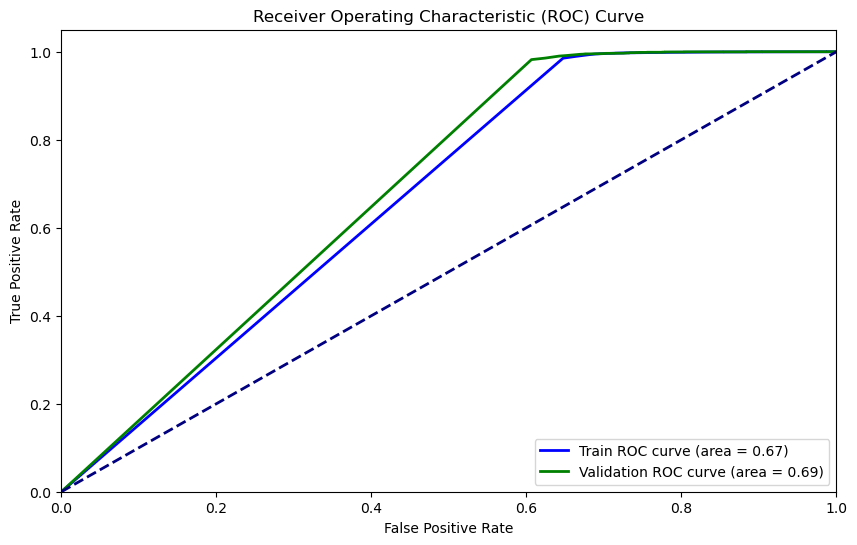

Confusion Matrix for Training Set:
[[  740 66547]
 [    3 67284]]
Confusion Matrix for Validation Set:
[[  227 22475]
 [    0  3239]]


In [23]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt

# Generate predictions for the resampled training set
train_probs_resampled = model_many_to_one.predict([train_features_event_resampled, train_features_case_resampled]).ravel()
train_labels_resampled_flat = train_labels_resampled.ravel()  # Flatten the labels

# Generate predictions for the validation set
val_probs = model_many_to_one.predict([val_features_event, val_features_case]).ravel()
val_labels_flat = val_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the training set
fpr_train, tpr_train, _ = roc_curve(train_labels_resampled_flat, train_probs_resampled)
roc_auc_train = auc(fpr_train, tpr_train)

# Compute ROC curve and AUC for the validation set
fpr_val, tpr_val, _ = roc_curve(val_labels_flat, val_probs)
roc_auc_val = auc(fpr_val, tpr_val)

# Plot ROC curves
plt.figure(figsize=(10, 6))

# ROC curve for training set
plt.plot(fpr_train, tpr_train, color='blue', lw=2, label='Train ROC curve (area = %0.2f)' % roc_auc_train)

# ROC curve for validation set
plt.plot(fpr_val, tpr_val, color='green', lw=2, label='Validation ROC curve (area = %0.2f)' % roc_auc_val)

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
train_preds_resampled = (train_probs_resampled > 0.5).astype(int)
val_preds = (val_probs > 0.5).astype(int)

# Compute confusion matrix for training set
cm_train_resampled = confusion_matrix(train_labels_resampled_flat, train_preds_resampled)
print("Confusion Matrix for Training Set:")
print(cm_train_resampled)

# Compute confusion matrix for validation set
cm_val = confusion_matrix(val_labels_flat, val_preds)
print("Confusion Matrix for Validation Set:")
print(cm_val)



811/811 [==============================] - 3s 4ms/step


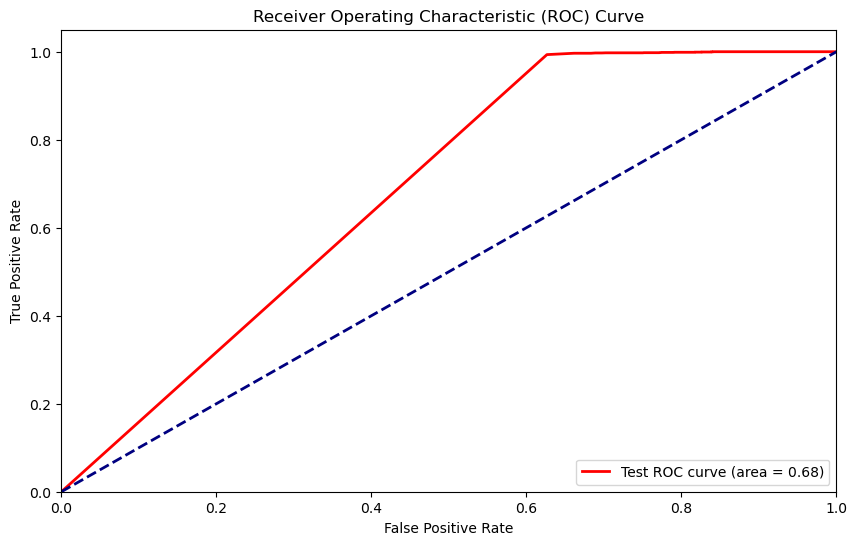

Confusion Matrix for Test Set:
[[  175 22577]
 [    0  3190]]


In [24]:

# Create TensorFlow dataset for the test data
test_dataset = tf.data.Dataset.from_tensor_slices(((test_features_event, test_features_case), test_labels)).batch(32)

# Generate predictions for the test set
test_probs = model_many_to_one.predict([test_features_event, test_features_case]).ravel()
test_labels_flat = test_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(test_labels_flat, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 6))

# ROC curve for test set
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)

# Diagonal line
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

# Labels and title
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Show plot
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
test_preds = (test_probs > 0.5).astype(int)

# Compute confusion matrix for test set
cm_test = confusion_matrix(test_labels_flat, test_preds)
print("Confusion Matrix for Test Set:")
print(cm_test)




In [25]:
test_loss, test_accuracy = model_many_to_one.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

811/811 [==============================] - 3s 4ms/step - loss: 19.2436 - accuracy: 0.1297
Test Loss: 19.243627548217773
Test Accuracy: 0.12971243262290955


# Looking at the Last Step

## Advantages:

Simplifies the interpretation by focusing on the final part of the sequence that directly contributes to the prediction.
Easier to understand and visualize.
Often sufficient if the final prediction is more influenced by the most recent information.

## Disadvantages:

Might miss important information from earlier time steps that contributed to the prediction.

In [26]:
# Ensure num_event_features is defined
num_event_features = len(event_feature_columns)

# Extract the last step event features from the test set
last_step_event_features = test_features_event[:, -1, :]

# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns


In [27]:
# Define a prediction function for LIME focusing on the last step
def predict_fn_last_step(data):
    # The input data contains both last step event features and case features
    num_samples = data.shape[0]
    
    # Split the data into last step event features and case features
    last_step_event_features = data[:, :num_event_features]
    case_features = data[:, num_event_features:]
    
    # Expand the last step event features to match the expected sequence length
    expanded_event_features = np.zeros((num_samples, sequence_length, num_event_features))
    expanded_event_features[:, -1, :] = last_step_event_features  # place the last step features at the last position
    
    # Make predictions using the trained model
    positive_class_probs = model_many_to_one.predict([expanded_event_features, case_features])
    
    # Convert single probability to two probabilities (positive and negative class)
    negative_class_probs = 1 - positive_class_probs
    return np.hstack((negative_class_probs, positive_class_probs))


In [28]:
import lime
from lime import lime_tabular

# Create a LIME explainer with feature names focused on the last step
explainer_last_step = lime_tabular.LimeTabularExplainer(
    X_test_combined_last_step, 
    feature_names=combined_feature_names_last_step,
    class_names=['Not_LWBS', 'LWBS'],
    mode='classification'
)

# Select a sample from the test set
sample_idx = 0  # Index of the sample to explain
sample_last_step_event = last_step_event_features[sample_idx]
sample_case = test_features_case[sample_idx]
sample_last_step = np.concatenate((sample_last_step_event, sample_case))

# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Show the explanation
exp_last_step.show_in_notebook(show_all=False)


157/157 [==============================] - 1s 4ms/step


157/157 [==============================] - 1s 4ms/step


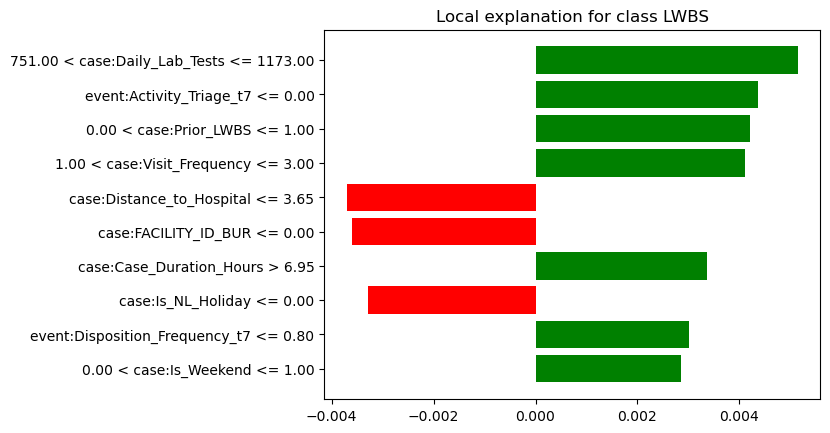

In [29]:
import matplotlib.pyplot as plt

# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Get the explanation as a matplotlib figure
fig = exp_last_step.as_pyplot_figure()



plt.show()


# model version  2

In [30]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define input shapes
event_feature_shape = (sequence_length, num_event_features)
case_feature_shape = (num_case_features,)

# Event features input
event_input = Input(shape=event_feature_shape, name='event_input')

# LSTM layers with dropout and L2 regularization
lstm_out = LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))(event_input)
lstm_out = Dropout(0.5)(lstm_out)  # Adding dropout

# Case features input
case_input = Input(shape=case_feature_shape, name='case_input')

# Concatenate case attributes
combined = Concatenate()([lstm_out, case_input])

# Final dense layer for classification with L2 regularization
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(combined)

# Define the model
model_with_regularization = Model(inputs=[event_input, case_input], outputs=output)
class_weights = {0: 1.0, 1: 10.0} 

model_with_regularization.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_with_regularization.summary()

# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and class weights
history_with_regularization = model_with_regularization.fit(
    train_dataset_resampled, 
    validation_data=val_dataset, 
    epochs=50,  
     class_weight=class_weights,
    callbacks=[early_stopping]
)


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 7, 14)]              0         []                            
                                                                                                  
 lstm_1 (LSTM)               (None, 64)                   20224     ['event_input[0][0]']         
                                                                                                  
 dropout (Dropout)           (None, 64)                   0         ['lstm_1[0][0]']              
                                                                                                  
 case_input (InputLayer)     [(None, 19)]                 0         []                            
                                                                                            

811/811 [==============================] - 4s 4ms/step


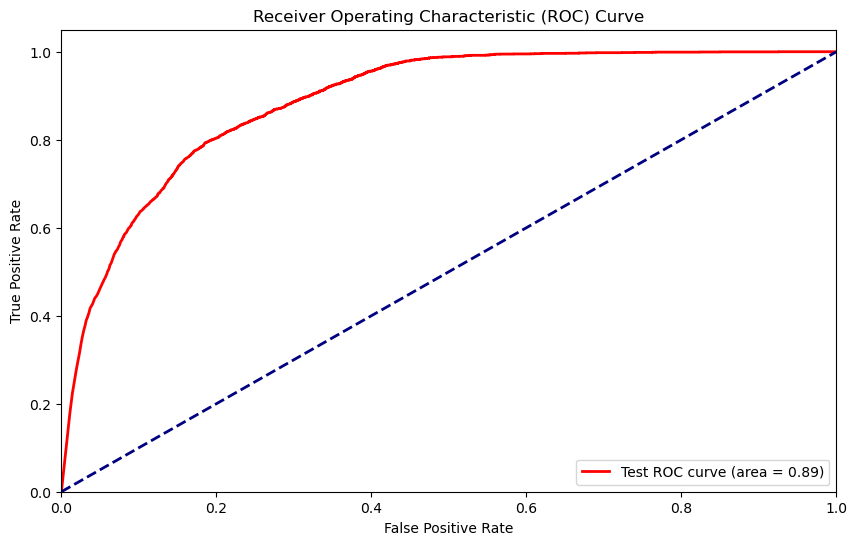

Confusion Matrix for Test Set:
[[   50 22702]
 [    0  3190]]


In [31]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
# Generate predictions for the test set
test_probs = model_with_regularization.predict([test_features_event, test_features_case]).ravel()
test_labels_flat = test_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(test_labels_flat, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
test_preds = (test_probs > 0.5).astype(int)

# Compute confusion matrix for test set
cm_test = confusion_matrix(test_labels_flat, test_preds)
print("Confusion Matrix for Test Set:")
print(cm_test)




In [32]:
test_loss, test_accuracy = model_with_regularization.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

811/811 [==============================] - 3s 4ms/step - loss: 6.4419 - accuracy: 0.1249
Test Loss: 6.4419426918029785
Test Accuracy: 0.12489399313926697


In [33]:
# Ensure num_event_features is defined
num_event_features = len(event_feature_columns)

# Extract the last step event features from the test set
last_step_event_features = test_features_event[:, -1, :]

# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns


In [34]:
# Define a prediction function for LIME focusing on the last step
def predict_fn_last_step(data):
    # The input data contains both last step event features and case features
    num_samples = data.shape[0]
    
    # Split the data into last step event features and case features
    last_step_event_features = data[:, :num_event_features]
    case_features = data[:, num_event_features:]
    
    # Expand the last step event features to match the expected sequence length
    expanded_event_features = np.zeros((num_samples, sequence_length, num_event_features))
    expanded_event_features[:, -1, :] = last_step_event_features  # place the last step features at the last position
    
    # Make predictions using the trained model
    positive_class_probs = model_with_regularization.predict([expanded_event_features, case_features])
    
    # Convert single probability to two probabilities (positive and negative class)
    negative_class_probs = 1 - positive_class_probs
    return np.hstack((negative_class_probs, positive_class_probs))


In [35]:
import lime
from lime import lime_tabular
# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns

# Create a LIME explainer with feature names focused on the last step
explainer_last_step = lime_tabular.LimeTabularExplainer(
    X_test_combined_last_step, 
    feature_names=combined_feature_names_last_step,
    class_names=['Not_LWBS', 'LWBS'],
    mode='classification'
)

# Select a sample from the test set
sample_idx = 0  # Index of the sample to explain
sample_last_step_event = last_step_event_features[sample_idx]
sample_case = test_features_case[sample_idx]
sample_last_step = np.concatenate((sample_last_step_event, sample_case))




In [36]:
# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Show the explanation
exp_last_step.show_in_notebook(show_all=False) 

157/157 [==============================] - 1s 4ms/step


157/157 [==============================] - 1s 4ms/step


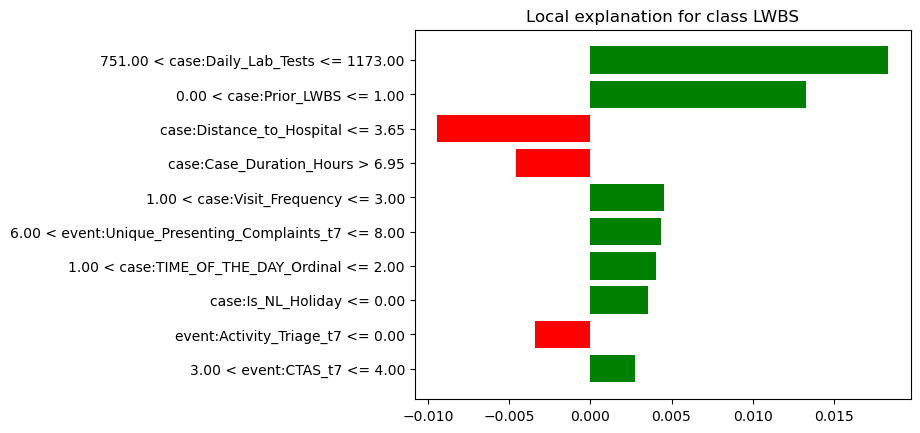

In [37]:
import matplotlib.pyplot as plt

# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Get the explanation as a matplotlib figure
fig = exp_last_step.as_pyplot_figure()




plt.show()


## model version 3

In [38]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Concatenate, Dropout, BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

# Define input shapes
event_feature_shape = (sequence_length, num_event_features)
case_feature_shape = (num_case_features,)

# Event features input
event_input = Input(shape=event_feature_shape, name='event_input')

# First LSTM layer with dropout and L2 regularization
lstm_out = LSTM(64, return_sequences=True, kernel_regularizer=l2(0.01))(event_input)
lstm_out = Dropout(0.5)(lstm_out)  # Adding dropout

# Second LSTM layer with dropout and L2 regularization
lstm_out = LSTM(64, return_sequences=False, kernel_regularizer=l2(0.01))(lstm_out)
lstm_out = Dropout(0.5)(lstm_out)  # Adding dropout

# Batch normalization
lstm_out = BatchNormalization()(lstm_out)

# Case features input
case_input = Input(shape=case_feature_shape, name='case_input')

# First dense layer for case features
case_dense = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(case_input)
case_dense = Dropout(0.5)(case_dense)  # Adding dropout
case_dense = BatchNormalization()(case_dense)

# Concatenate case attributes
combined = Concatenate()([lstm_out, case_dense])

# Additional dense layers for the combined features
dense_out = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(combined)
dense_out = Dropout(0.5)(dense_out)  # Adding dropout
dense_out = BatchNormalization()(dense_out)

dense_out = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(dense_out)
dense_out = Dropout(0.5)(dense_out)  # Adding dropout
dense_out = BatchNormalization()(dense_out)

# Final dense layer for classification with L2 regularization
output = Dense(1, activation='sigmoid', kernel_regularizer=l2(0.01))(dense_out)

# Define the model
model_with_enhancements = Model(inputs=[event_input, case_input], outputs=output)
class_weights = {0: 1.0, 1: 10.0} 

model_with_enhancements.compile(optimizer=Adam(learning_rate=0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print the model summary
model_with_enhancements.summary()

# Define early stopping callback
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with early stopping and class weights
history_with_enhancements = model_with_enhancements.fit(
    train_dataset_resampled, 
    validation_data=val_dataset, 
    epochs=50,  
     class_weight=class_weights,
    callbacks=[early_stopping]
)


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 event_input (InputLayer)    [(None, 7, 14)]              0         []                            
                                                                                                  
 lstm_2 (LSTM)               (None, 7, 64)                20224     ['event_input[0][0]']         
                                                                                                  
 dropout_1 (Dropout)         (None, 7, 64)                0         ['lstm_2[0][0]']              
                                                                                                  
 case_input (InputLayer)     [(None, 19)]                 0         []                            
                                                                                            

811/811 [==============================] - 6s 6ms/step


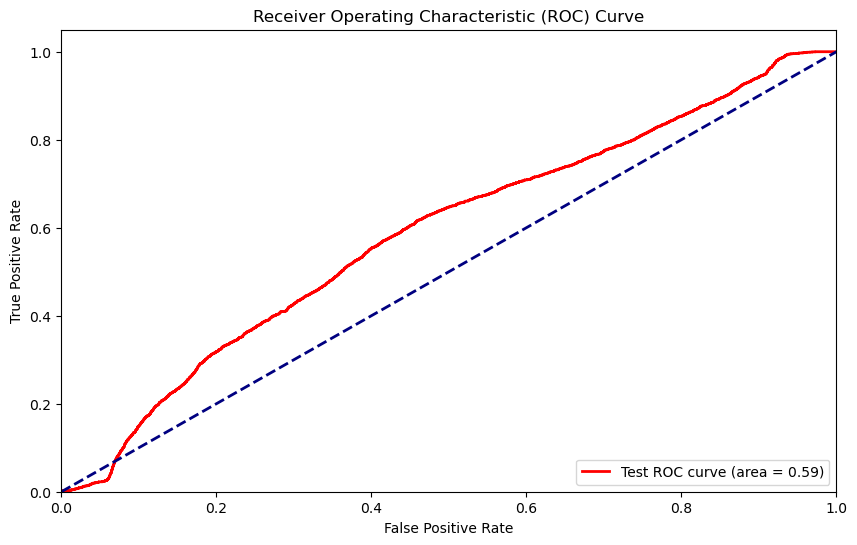

Confusion Matrix for Test Set:
[[    0 22752]
 [    0  3190]]


In [39]:
from sklearn.metrics import roc_curve, auc, confusion_matrix, classification_report
import matplotlib.pyplot as plt
# Generate predictions for the test set
test_probs = model_with_enhancements.predict([test_features_event, test_features_case]).ravel()
test_labels_flat = test_labels.ravel()  # Flatten the labels

# Compute ROC curve and AUC for the test set
fpr_test, tpr_test, _ = roc_curve(test_labels_flat, test_probs)
roc_auc_test = auc(fpr_test, tpr_test)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr_test, tpr_test, color='red', lw=2, label='Test ROC curve (area = %0.2f)' % roc_auc_test)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

# Convert probabilities to binary predictions based on a threshold of 0.5
test_preds = (test_probs > 0.5).astype(int)

# Compute confusion matrix for test set
cm_test = confusion_matrix(test_labels_flat, test_preds)
print("Confusion Matrix for Test Set:")
print(cm_test)




In [40]:
test_loss, test_accuracy = model_with_enhancements.evaluate(test_dataset)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)

811/811 [==============================] - 5s 6ms/step - loss: 2.9093 - accuracy: 0.1230
Test Loss: 2.9092931747436523
Test Accuracy: 0.12296661734580994


In [41]:


# Ensure num_event_features is defined
num_event_features = len(event_feature_columns)

# Extract the last step event features from the test set
last_step_event_features = test_features_event[:, -1, :]

# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns


In [42]:
# Define a prediction function for LIME focusing on the last step
def predict_fn_last_step(data):
    # The input data contains both last step event features and case features
    num_samples = data.shape[0]
    
    # Split the data into last step event features and case features
    last_step_event_features = data[:, :num_event_features]
    case_features = data[:, num_event_features:]
    
    # Reshape the last step event features to match the model's input shape
    last_step_event_features = last_step_event_features.reshape((num_samples, 1, num_event_features))
    
    # Make predictions using the trained model
    positive_class_probs = model_with_enhancements.predict([last_step_event_features, case_features])
    
    # Convert single probability to two probabilities (positive and negative class)
    negative_class_probs = 1 - positive_class_probs
    return np.hstack((negative_class_probs, positive_class_probs))

In [43]:
import lime
from lime import lime_tabular
# Combine the last step event features with case features
X_test_combined_last_step = np.hstack([last_step_event_features, test_features_case])

# Create meaningful feature names for the last step
last_step_event_feature_names = [f'{feature}_t{sequence_length}' for feature in event_feature_columns]

# Combine with case feature names
combined_feature_names_last_step = last_step_event_feature_names + case_feature_columns

# Create a LIME explainer with feature names focused on the last step
explainer_last_step = lime_tabular.LimeTabularExplainer(
    X_test_combined_last_step, 
    feature_names=combined_feature_names_last_step,
    class_names=['Not_LWBS', 'LWBS'],
    mode='classification'
)

# Select a sample from the test set
sample_idx = 0  # Index of the sample to explain
sample_last_step_event = last_step_event_features[sample_idx]
sample_case = test_features_case[sample_idx]
sample_last_step = np.concatenate((sample_last_step_event, sample_case))




In [44]:
# Explain the selected sample
exp_last_step = explainer_last_step.explain_instance(sample_last_step, predict_fn_last_step)

# Show the explanation
exp_last_step.show_in_notebook(show_all=False) # Explain the selected sample


157/157 [==============================] - 2s 3ms/step


                                          Feature  Importance
0        751.00 < case:Daily_Lab_Tests <= 1173.00    0.001002
1  event:PRESENTING_COMPLAINT_ENCODED_t7 > 141.00    0.000339
2               case:Daily_Imaging_Tests > 128.00   -0.000266
3                 case:Case_Duration_Hours > 6.95   -0.000194
4               case:Distance_to_Hospital <= 3.65    0.000160
5                 3.00 < case:Day_of_Week <= 5.00    0.000128
6       event:Rolling_Std_Inverse_CTAS_t7 <= 0.00   -0.000122
7                  event:Num_Lab_Tests_t7 <= 0.00   -0.000112
8                        case:Is_Deceased <= 0.00    0.000108
9       0.00 < event:Activity_Duration_t7 <= 0.17   -0.000104


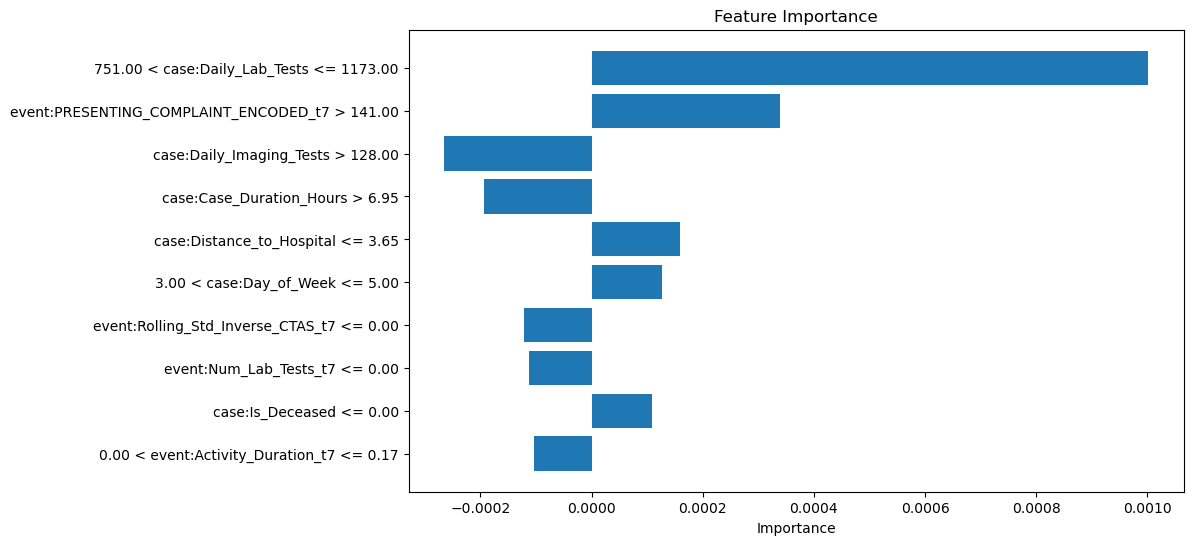

In [45]:
# Convert explanation to DataFrame
feature_importance = pd.DataFrame(exp_last_step.as_list(), columns=['Feature', 'Importance'])

# Display the DataFrame
print(feature_importance)

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.gca().invert_yaxis()
plt.show()